In [1]:
#Libraries
from time import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(rc={'figure.figsize':(18,6)},style='darkgrid')
import statsmodels.api as sm
from imblearn.over_sampling import RandomOverSampler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split,StratifiedKFold,cross_val_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import *
import warnings
warnings.filterwarnings('ignore')

In [ ]:
#Importing Data
df = pd.read_csv("../data/user_data.csv")
df.head()

,User ID,Gender,Age,EstimatedSalary,Purchased
0,15624510,Male,19,19000,0
1,15810944,Male,35,20000,0
2,15668575,Female,26,43000,0
3,15603246,Female,27,57000,0
4,15804002,Male,19,76000,0


#### Data Wrangling

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400 entries, 0 to 399
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   User ID          400 non-null    int64 
 1   Gender           400 non-null    object
 2   Age              400 non-null    int64 
 3   EstimatedSalary  400 non-null    int64 
 4   Purchased        400 non-null    int64 
dtypes: int64(4), object(1)
memory usage: 15.8+ KB


In [4]:
df.describe(include='all')

,User ID,Gender,Age,EstimatedSalary,Purchased
count,4.000000e+02,400,400.000000,400.000000,400.000000
unique,NaN,2,NaN,NaN,NaN
top,NaN,Female,NaN,NaN,NaN
freq,NaN,204,NaN,NaN,NaN
mean,1.569154e+07,NaN,37.655000,69742.500000,0.357500
std,7.165832e+04,NaN,10.482877,34096.960282,0.479864
min,1.556669e+07,NaN,18.000000,15000.000000,0.000000
25%,1.562676e+07,NaN,29.750000,43000.000000,0.000000
50%,1.569434e+07,NaN,37.000000,70000.000000,0.000000
75%,1.575036e+07,NaN,46.000000,88000.000000,1.000000


In [5]:
df.duplicated().sum()

0

In [6]:
df['User ID'].duplicated().sum()

0

In [7]:
df.drop('User ID',axis=1,inplace=True)

#### Univariate Analysis

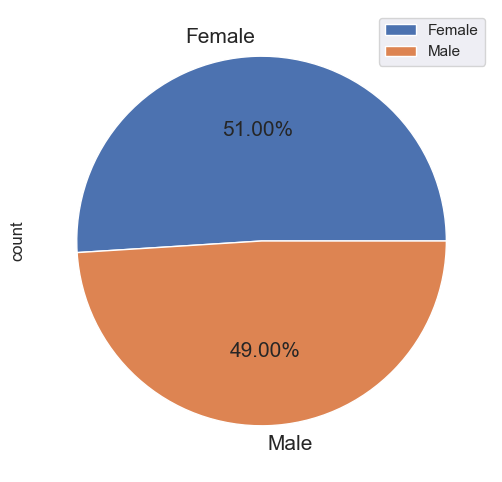

In [8]:
df['Gender'].value_counts().plot(kind='pie',autopct='%.2f%%',legend=True,fontsize=15)
plt.show()

<Axes: xlabel='Age', ylabel='Density'>

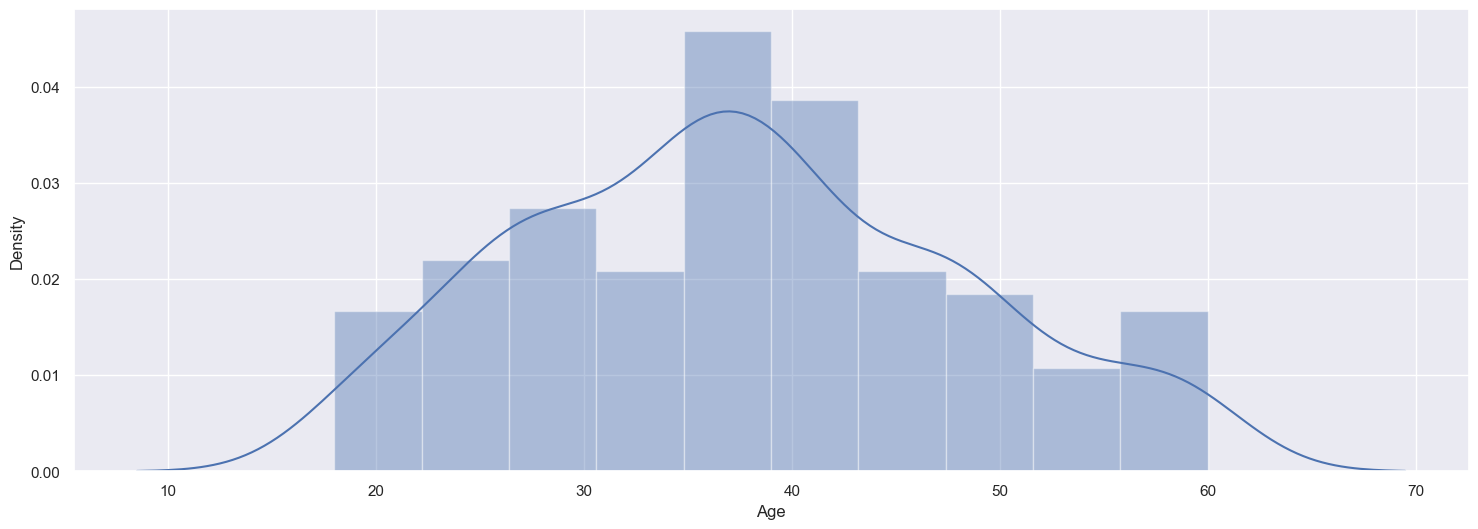

In [9]:
sns.distplot(df['Age'],bins=10)

<Axes: xlabel='EstimatedSalary'>

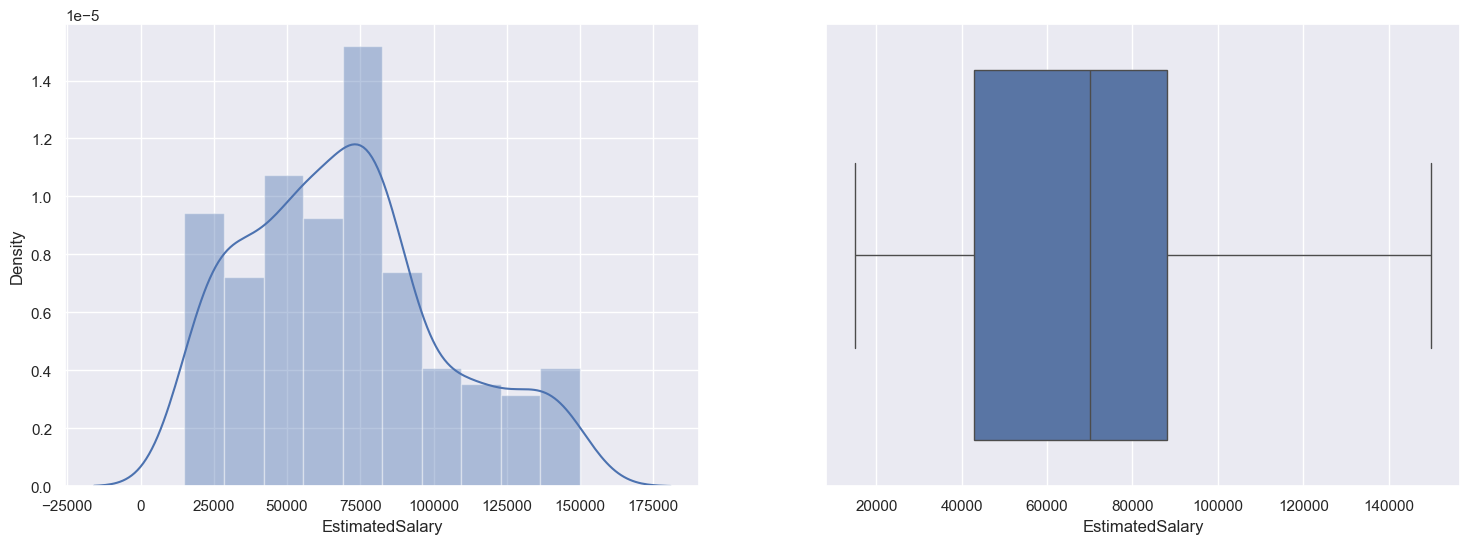

In [10]:
_,axs = plt.subplots(1,2)
sns.distplot(df['EstimatedSalary'],bins=10,ax=axs[0])
sns.boxplot(x=df['EstimatedSalary'],ax=axs[1])

<Axes: ylabel='count'>

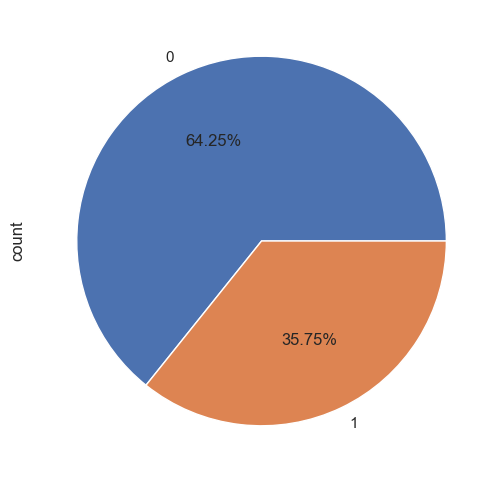

In [11]:
df['Purchased'].value_counts().plot(kind='pie',autopct='%.2f%%')

#### Bivariate

<Axes: xlabel='Gender', ylabel='EstimatedSalary'>

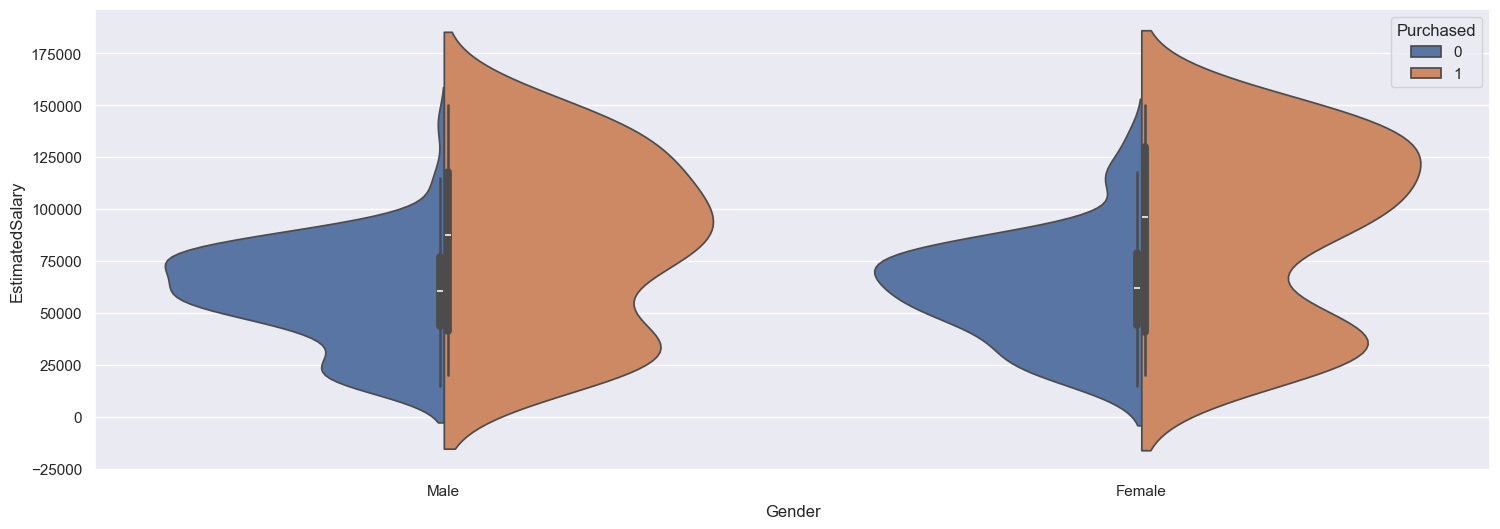

In [12]:
sns.violinplot(data=df,y='EstimatedSalary',x='Gender',hue='Purchased',split=True)

<Axes: xlabel='Gender', ylabel='Purchased'>

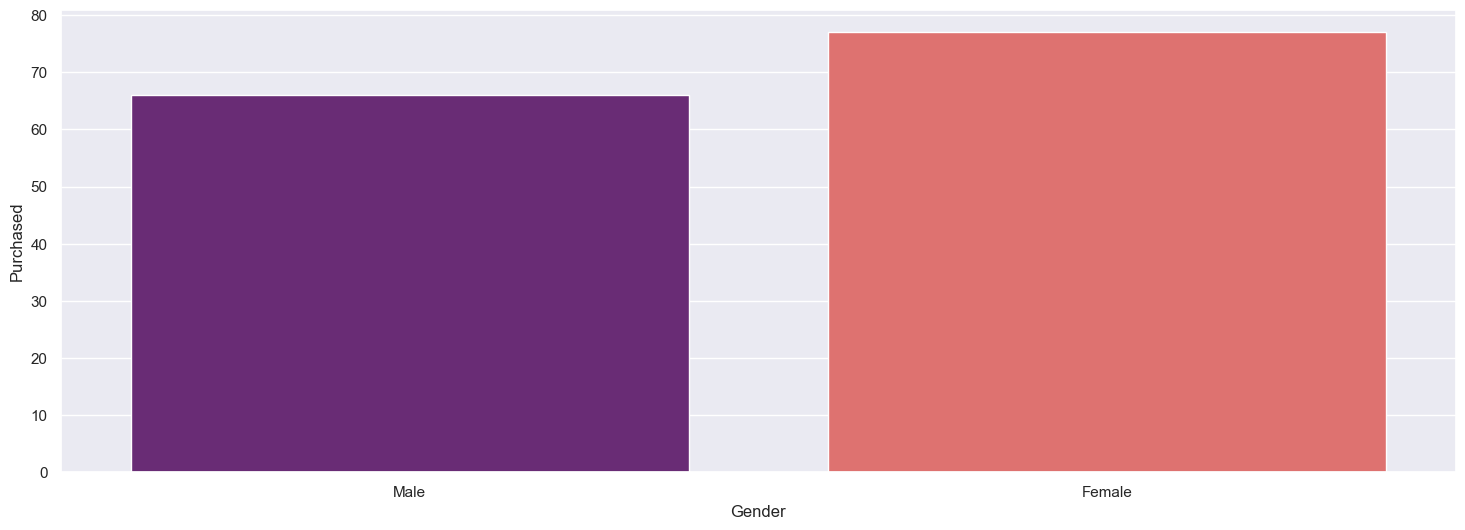

In [13]:
sns.barplot(data=df,x='Gender',y='Purchased',estimator=sum,ci=None,palette='magma')

<Axes: xlabel='Age', ylabel='EstimatedSalary'>

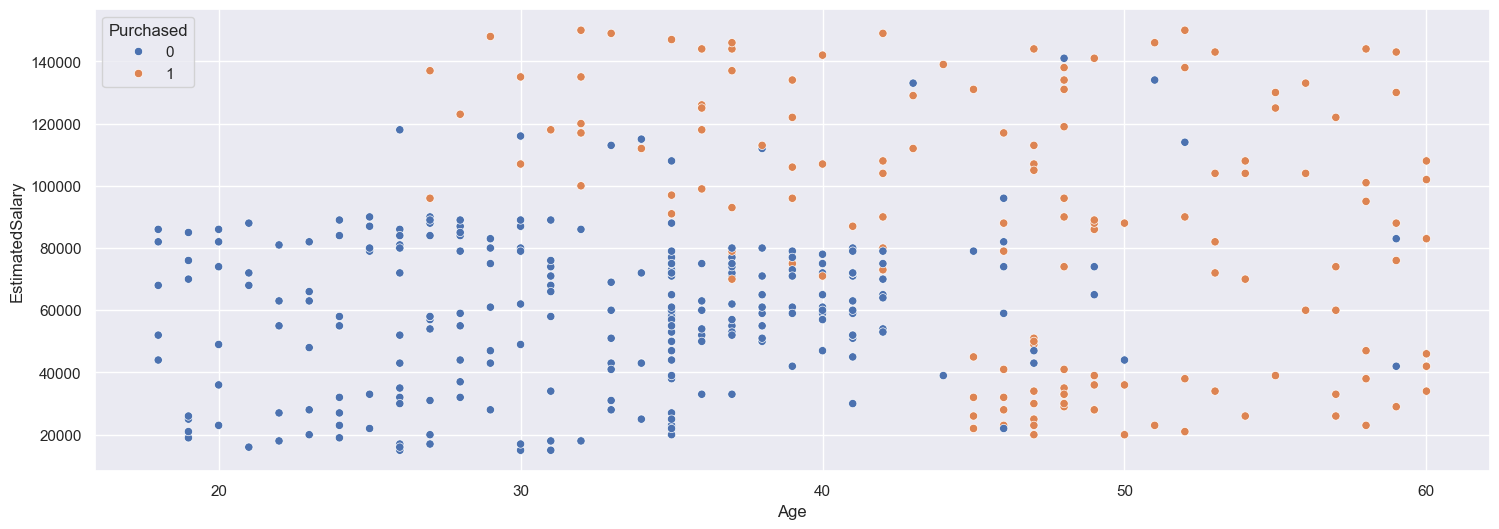

In [14]:
sns.scatterplot(data=df,x='Age',y='EstimatedSalary',hue='Purchased')

In [15]:
corr_mat = df[['Age','Purchased','EstimatedSalary']].corr()

<Axes: >

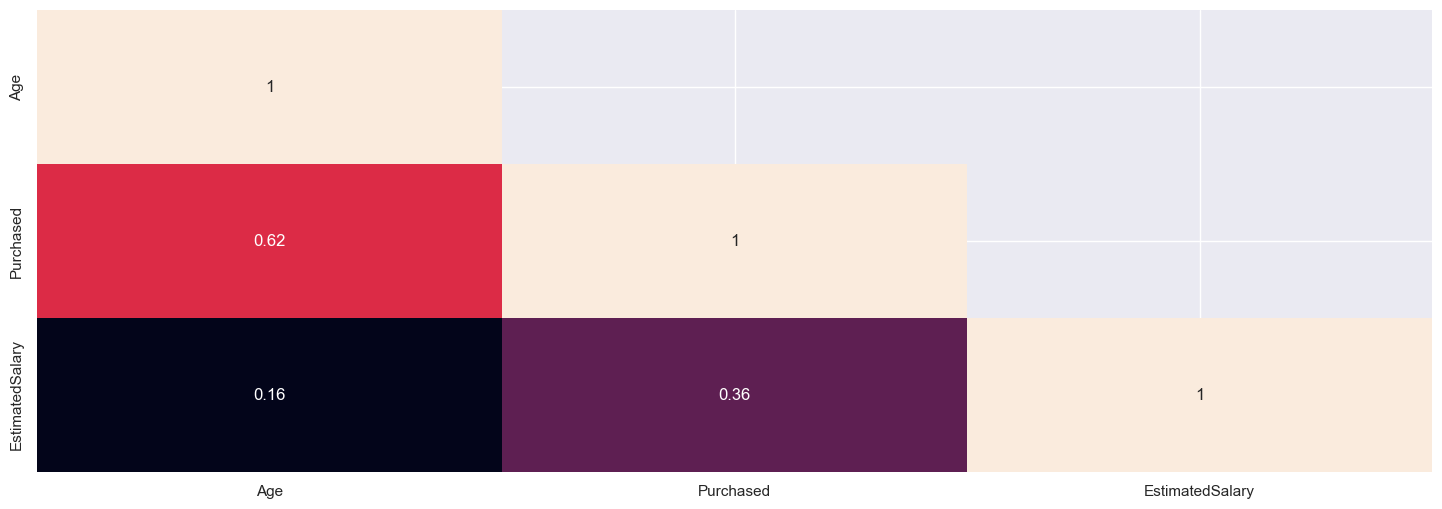

In [16]:
sns.heatmap(data=corr_mat,
           annot=True,
           cbar=False,
           cmap='rocket',
           mask = np.triu(np.ones_like(corr_mat,dtype=bool),k=1))

In [17]:
df = pd.get_dummies(data=df,columns=['Gender'],drop_first=True,dtype='int8')

In [18]:
df.head()

,Age,EstimatedSalary,Purchased,Gender_Male
0,19,19000,0,1
1,35,20000,0,1
2,26,43000,0,0
3,27,57000,0,0
4,19,76000,0,1


## Model Buliding

In [19]:
x = df.drop('Purchased',axis=1)
y= df['Purchased']

In [20]:
#Split train,test data
x_train,x_test,y_train,y_test = train_test_split(x,y,train_size=0.8,shuffle=True,random_state=10)

In [21]:
#Scale data
scaler = MinMaxScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

In [22]:
#Logistic Regression Model
model = LogisticRegression(random_state=10)

In [23]:
#Testing data accuracy on training data to comapre it with prediction after fitting
skf = StratifiedKFold(n_splits=5,shuffle=True,random_state=10)
scores = cross_val_score(model,x_train,y_train,cv=skf,scoring='accuracy')
print('Scores Mean =',scores.mean().round(2))

Scores Mean = 0.81


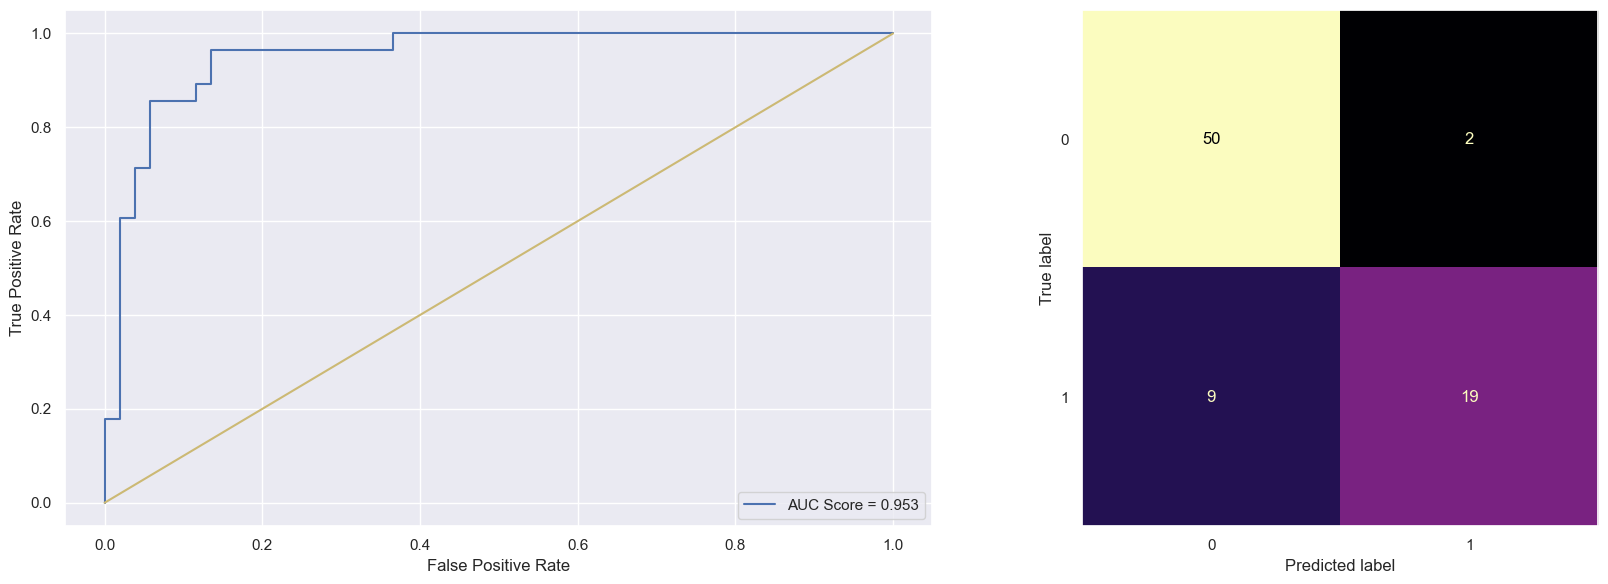

Recall Score:  0.679
Precision:  0.905
F1-Score:  0.776
Accuracy Score:  0.862
AUC Score:  0.953


In [24]:
_,axs = plt.subplots(1,2)
model.fit(x_train,y_train)
y_pred = model.predict(x_test)
#AUC-ROC Curve
y_proba = model.predict_proba(x_test)
fpr, tpr, _ = roc_curve(y_test, y_proba[:, 1])
roc_display = RocCurveDisplay(fpr=fpr, tpr=tpr).plot(ax=axs[0],label=f'AUC Score = {roc_auc_score(y_test,y_proba[:,1]).round(3)}')
axs[0].plot([0, 1], [0, 1], color = 'y')
#Confusion Matrix
cm = confusion_matrix(y_test,y_pred,labels=model.classes_)
cmd = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=model.classes_)
cmd.plot(colorbar=False,ax=axs[1],cmap='magma')
axs[1].grid(False)
plt.tight_layout()
plt.show()
#Scores
print(f'Recall Score: ',recall_score(y_test,y_pred).round(3))
print('Precision: ',precision_score(y_test,y_pred).round(3))
print('F1-Score: ',f1_score(y_test,y_pred).round(3))
print('Accuracy Score: ',accuracy_score(y_test,y_pred).round(3))
print('AUC Score: ',roc_auc_score(y_test,y_proba[:,1]).round(3))

- Model can diffrenciate between positive and negative instances well as AUC score = 96%
- We discover a weak recall
- Accuracy can be missleading here since the data is slightly imbalanced, so we can consider another model to deal with imbalanced data, balance data using oversampling or undersampling or providing class weights to model